In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.float_format', '{:.2f}'.format)

# Charger les données nettoyées
df = pd.read_pickle('C:/Users/Moi/E-commerce_Marketing_Analytics/data/processed/cleaned_ecommerce_data.pkl')

In [8]:
# ============================================================================
# 🔧 CORRECTION : DÉFINITION CHURN RÉALISTE
# ============================================================================

class ChurnPredictorFixed:
    """
    🔮 Modèle de prédiction de churn corrigé (pas de data leakage)
    """
    
    def __init__(self):
        self.models = {}
        self.scaler = StandardScaler()
        self.feature_importance = {}
        
    def create_churn_features_fixed(self, df):
        """
        🛠️ Feature Engineering SANS data leakage
        """
        print("🛠️ CRÉATION FEATURES DE CHURN (VERSION CORRIGÉE)...")
        
        # ===== APPROCHE TEMPORELLE RÉALISTE =====
        # On va diviser les données en 2 périodes:
        # - Période d'observation (premiers 80% du temps)  
        # - Période de prédiction (derniers 20% du temps)
        
        df_sorted = df.sort_values('InvoiceDate')
        date_cutoff = df_sorted['InvoiceDate'].quantile(0.8)  # 80% des données
        observation_end = df_sorted['InvoiceDate'].quantile(0.6)  # Pour observer les tendances
        
        print(f"📅 Date limite observation: {observation_end}")
        print(f"📅 Date cutoff prédiction: {date_cutoff}")
        print(f"📅 Fin dataset: {df_sorted['InvoiceDate'].max()}")
        
        # ===== PÉRIODE D'OBSERVATION (pour créer les features) =====
        observation_data = df_sorted[df_sorted['InvoiceDate'] <= observation_end]
        print(f"📊 Données observation: {len(observation_data)} transactions")
        
        # Features calculées sur la période d'observation UNIQUEMENT
        customer_features = observation_data.groupby('Customer ID').agg({
            'InvoiceDate': ['min', 'max', 'count'],
            'Quantity': ['sum', 'mean', 'std'],
            'Price': ['mean', 'std'],
            'Total_Amount': ['sum', 'mean', 'std'],
            'Invoice': 'nunique',
            'StockCode': 'nunique'
        }).round(2)
        
        customer_features.columns = ['_'.join(col).strip() for col in customer_features.columns]
        
        # Features temporelles (basées sur période d'observation)
        customer_features['days_active'] = (
            customer_features['InvoiceDate_max'] - customer_features['InvoiceDate_min']
        ).dt.days
        
        customer_features['time_since_first_purchase'] = (
            observation_end - customer_features['InvoiceDate_min']
        ).dt.days
        
        # Suppression colonnes datetime
        customer_features = customer_features.drop(['InvoiceDate_min', 'InvoiceDate_max'], axis=1)
        
        # Features comportementales
        customer_features['purchase_frequency'] = (
            customer_features['InvoiceDate_count'] / 
            (customer_features['days_active'] + 1) * 30
        )
        
        customer_features['avg_order_value'] = (
            customer_features['Total_Amount_sum'] / customer_features['Invoice_nunique']
        )
        
        customer_features['product_diversity'] = customer_features['StockCode_nunique']
        
        customer_features['spending_volatility'] = (
            customer_features['Total_Amount_std'] / 
            (customer_features['Total_Amount_mean'] + 1)
        )
        
        # ===== CALCUL DU CHURN (sur période future) =====
        # Clients qui achètent dans la période d'observation
        active_customers = set(observation_data['Customer ID'].unique())
        
        # Clients qui achètent dans la période de prédiction
        prediction_data = df_sorted[
            (df_sorted['InvoiceDate'] > observation_end) & 
            (df_sorted['InvoiceDate'] <= date_cutoff)
        ]
        future_customers = set(prediction_data['Customer ID'].unique())
        
        print(f"👥 Clients actifs période obs: {len(active_customers)}")
        print(f"👥 Clients actifs période future: {len(future_customers)}")
        
        # Définition du churn: client actif en observation MAIS pas en prédiction
        churned_customers = active_customers - future_customers
        
        customer_features['is_churned'] = customer_features.index.isin(churned_customers).astype(int)
        
        # Nettoyage données
        customer_features = customer_features.fillna(0)
        customer_features = customer_features.replace([np.inf, -np.inf], 0)
        
        # Filtrage: garder seulement clients avec minimum d'activité
        min_purchases = 3
        customer_features = customer_features[customer_features['Invoice_nunique'] >= min_purchases]
        
        print(f"✅ Features créées: {customer_features.shape}")
        print(f"📊 Taux de churn: {customer_features['is_churned'].mean():.2%}")
        
        return customer_features
    
    def train_models_fixed(self, features_df):
        """
        🤖 Entraînement modèles avec validation croisée
        """
        print("🤖 ENTRAÎNEMENT MODÈLES (VERSION CORRIGÉE)...")
        
        feature_cols = [col for col in features_df.columns if col != 'is_churned']
        X = features_df[feature_cols].astype(float)
        y = features_df['is_churned']
        
        print(f"📊 Dataset: {X.shape[0]} clients, {X.shape[1]} features")
        print(f"📊 Distribution: Actifs={sum(y==0)}, Churn={sum(y==1)}")
        
        # Vérification équilibre des classes
        if y.mean() < 0.05 or y.mean() > 0.95:
            print("⚠️ ATTENTION: Classes déséquilibrées détectées")
        
        # Split stratifié
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Normalisation
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        # ===== ENTRAÎNEMENT AVEC VALIDATION CROISÉE =====
        models_to_test = {
            'logistic': LogisticRegression(random_state=42, max_iter=1000),
            'random_forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10),
            'xgboost': xgb.XGBClassifier(n_estimators=100, random_state=42, max_depth=6)
        }
        
        results = {}
        
        for name, model in models_to_test.items():
            print(f"\n🔄 Test {name.upper()}...")
            
            # Cross-validation
            if name == 'logistic':
                cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
                model.fit(X_train_scaled, y_train)
                test_pred = model.predict_proba(X_test_scaled)[:, 1]
            else:
                cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
                model.fit(X_train, y_train)
                test_pred = model.predict_proba(X_test)[:, 1]
            
            test_auc = roc_auc_score(y_test, test_pred)
            
            print(f"✅ CV AUC: {cv_scores.mean():.3f} (+/- {cv_scores.std()*2:.3f})")
            print(f"✅ Test AUC: {test_auc:.3f}")
            
            self.models[name] = model
            results[name] = {
                'cv_auc': cv_scores.mean(),
                'test_auc': test_auc,
                'cv_std': cv_scores.std()
            }
        
        # Sélection meilleur modèle
        best_model = max(results.keys(), key=lambda x: results[x]['test_auc'])
        
        print(f"\n🏆 MEILLEUR MODÈLE: {best_model.upper()}")
        print(f"📊 AUC Test: {results[best_model]['test_auc']:.3f}")
        
        return results

# ============================================================================
# 🚀 RELANCEMENT AVEC CORRECTION
# ============================================================================

print("🔧 RELANCEMENT AVEC DÉFINITION CHURN CORRIGÉE...")
churn_predictor_fixed = ChurnPredictorFixed()

print("🛠️ CRÉATION FEATURES SANS DATA LEAKAGE...")
churn_features_fixed = churn_predictor_fixed.create_churn_features_fixed(df)

print("🤖 ENTRAÎNEMENT MODÈLES AVEC VALIDATION CROISÉE...")
results_fixed = churn_predictor_fixed.train_models_fixed(churn_features_fixed)


🔧 RELANCEMENT AVEC DÉFINITION CHURN CORRIGÉE...
🛠️ CRÉATION FEATURES SANS DATA LEAKAGE...
🛠️ CRÉATION FEATURES DE CHURN (VERSION CORRIGÉE)...
📅 Date limite observation: 2011-03-16 14:00:00
📅 Date cutoff prédiction: 2011-09-08 10:49:00
📅 Fin dataset: 2011-12-09 12:50:00
📊 Données observation: 624549 transactions
👥 Clients actifs période obs: 152131
👥 Clients actifs période future: 54663
✅ Features créées: (2570, 18)
📊 Taux de churn: 37.24%
🤖 ENTRAÎNEMENT MODÈLES AVEC VALIDATION CROISÉE...
🤖 ENTRAÎNEMENT MODÈLES (VERSION CORRIGÉE)...
📊 Dataset: 2570 clients, 17 features
📊 Distribution: Actifs=1613, Churn=957

🔄 Test LOGISTIC...
✅ CV AUC: 0.766 (+/- 0.022)
✅ Test AUC: 0.766

🔄 Test RANDOM_FOREST...
✅ CV AUC: 0.743 (+/- 0.026)
✅ Test AUC: 0.746

🔄 Test XGBOOST...
✅ CV AUC: 0.716 (+/- 0.029)
✅ Test AUC: 0.754

🏆 MEILLEUR MODÈLE: LOGISTIC
📊 AUC Test: 0.766


🚀 LANCEMENT ANALYSE COMPLÈTE DU CHURN...
📊 ANALYSE AVANCÉE DU MODÈLE DE CHURN

🔍 TOP 10 FEATURES LES PLUS IMPORTANTES:
                  feature  importance  coefficient
          Invoice_nunique        1.45        -1.45
         Total_Amount_std        1.08         1.08
              days_active        0.87        -0.87
time_since_first_purchase        0.83         0.83
             Quantity_sum        0.82         0.82
               Price_mean        0.65         0.65
        Total_Amount_mean        0.52        -0.52
             Quantity_std        0.52        -0.52
        InvoiceDate_count        0.38         0.38
        product_diversity        0.31        -0.31


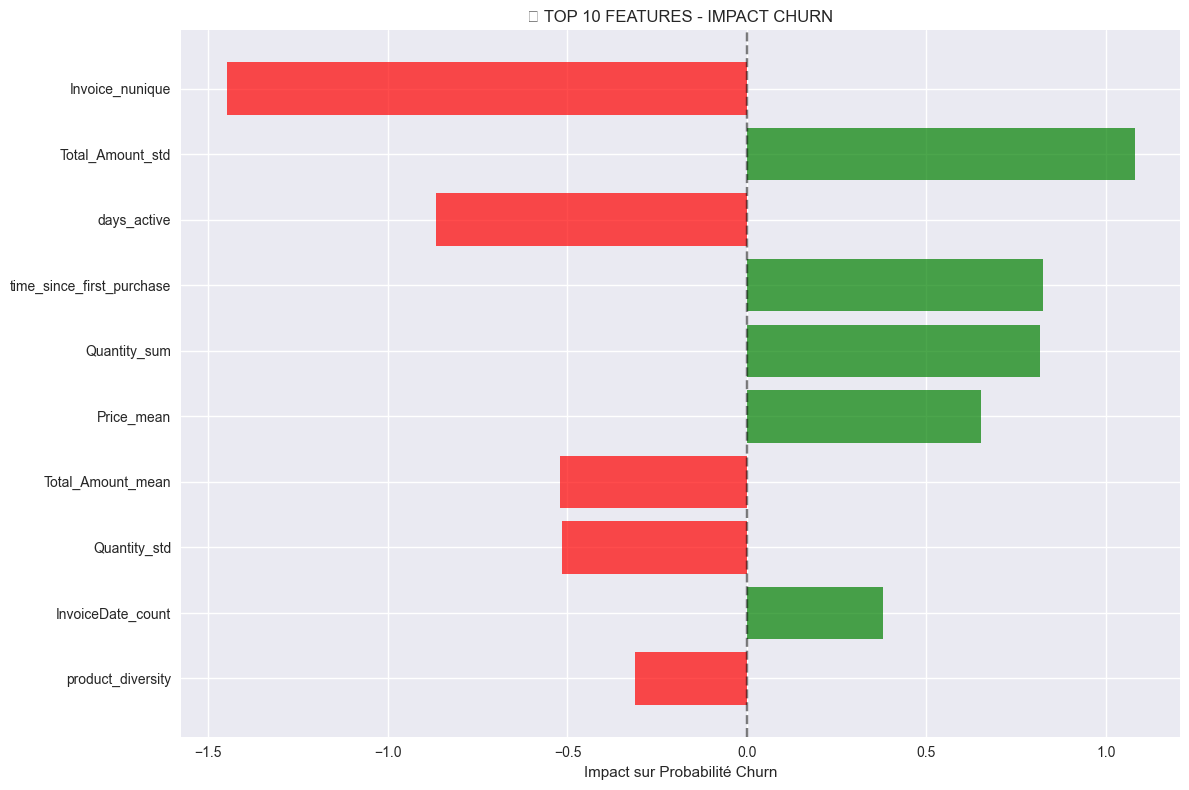


📊 SEGMENTATION PAR RISQUE DE CHURN:
             is_churned           Total_Amount_sum purchase_frequency  \
                  count  sum mean             mean               mean   
risk_segment                                                            
🟢 Faible           1020  142 0.14          7000.66              32.91   
🟡 Moyen            1354  662 0.49          1235.45              27.23   
🔴 Élevé             196  153 0.78           610.65              89.06   

             avg_order_value churn_probability            
                        mean              mean  min  max  
risk_segment                                              
🟢 Faible              403.82              0.16 0.00 0.30  
🟡 Moyen               247.84              0.47 0.30 0.70  
🔴 Élevé               138.52              0.81 0.70 1.00  

💰 IMPACT BUSINESS:
📊 Clients total analysés: 2,570
🔴 Clients haut risque: 196
💰 Valeur client moyenne: 3475.94£
⚠️ Perte potentielle: 681,283.54£

💡 STRATÉGIE DE RÉTENTI

In [9]:
# ============================================================================
# 📊 ANALYSE AVANCÉE DU MODÈLE DE CHURN
# ============================================================================

def analyze_churn_model(churn_predictor_fixed, churn_features_fixed):
    """
    📊 Analyse complète du modèle de churn
    """
    print("📊 ANALYSE AVANCÉE DU MODÈLE DE CHURN")
    print("=" * 60)
    
    # ===== 1. FEATURE IMPORTANCE =====
    print("\n🔍 TOP 10 FEATURES LES PLUS IMPORTANTES:")
    
    best_model = churn_predictor_fixed.models['logistic']
    feature_cols = [col for col in churn_features_fixed.columns if col != 'is_churned']
    
    # Coefficients logistic (valeur absolue)
    if hasattr(best_model, 'coef_'):
        feature_importance = pd.DataFrame({
            'feature': feature_cols,
            'importance': np.abs(best_model.coef_[0]),
            'coefficient': best_model.coef_[0]
        }).sort_values('importance', ascending=False)
        
        print(feature_importance.head(10).to_string(index=False))
        
        # Visualisation
        plt.figure(figsize=(12, 8))
        top_features = feature_importance.head(10)
        
        colors = ['red' if x < 0 else 'green' for x in top_features['coefficient']]
        plt.barh(range(len(top_features)), top_features['coefficient'], color=colors, alpha=0.7)
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Impact sur Probabilité Churn')
        plt.title('🎯 TOP 10 FEATURES - IMPACT CHURN')
        plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    
    # ===== 2. ANALYSE PAR SEGMENTS DE RISQUE =====
    print("\n📊 SEGMENTATION PAR RISQUE DE CHURN:")
    
    # Prédictions sur tout le dataset
    X_full = churn_features_fixed[feature_cols]
    X_full_scaled = churn_predictor_fixed.scaler.transform(X_full)
    
    churn_probas = best_model.predict_proba(X_full_scaled)[:, 1]
    
    # Création des segments
    churn_features_fixed['churn_probability'] = churn_probas
    churn_features_fixed['risk_segment'] = pd.cut(
        churn_probas, 
        bins=[0, 0.3, 0.7, 1.0], 
        labels=['🟢 Faible', '🟡 Moyen', '🔴 Élevé']
    )
    
    # Analyse par segment
    segment_analysis = churn_features_fixed.groupby('risk_segment').agg({
        'is_churned': ['count', 'sum', 'mean'],
        'Total_Amount_sum': 'mean',
        'purchase_frequency': 'mean',
        'avg_order_value': 'mean',
        'churn_probability': ['mean', 'min', 'max']
    }).round(3)
    
    print(segment_analysis)
    
    # ===== 3. MÉTRIQUES BUSINESS =====
    print("\n💰 IMPACT BUSINESS:")
    
    # Calcul de la valeur-client moyenne
    avg_customer_value = churn_features_fixed['Total_Amount_sum'].mean()
    
    # Clients à haut risque (prob > 0.7)
    high_risk_clients = churn_features_fixed[churn_features_fixed['churn_probability'] > 0.7]
    clients_at_risk = len(high_risk_clients)
    potential_loss = clients_at_risk * avg_customer_value
    
    print(f"📊 Clients total analysés: {len(churn_features_fixed):,}")
    print(f"🔴 Clients haut risque: {clients_at_risk:,}")
    print(f"💰 Valeur client moyenne: {avg_customer_value:.2f}£")
    print(f"⚠️ Perte potentielle: {potential_loss:,.2f}£")
    
    # Coût rétention vs bénéfice
    retention_cost_per_client = 50  # Estimation
    retention_success_rate = 0.3    # 30% de succès
    
    total_retention_cost = clients_at_risk * retention_cost_per_client
    expected_retention = clients_at_risk * retention_success_rate
    expected_saved_value = expected_retention * avg_customer_value
    roi_retention = (expected_saved_value - total_retention_cost) / total_retention_cost * 100
    
    print(f"\n💡 STRATÉGIE DE RÉTENTION:")
    print(f"💸 Coût campagne rétention: {total_retention_cost:,.2f}£")
    print(f"🎯 Clients sauvés (estimé): {expected_retention:.0f}")
    print(f"💰 Valeur sauvée: {expected_saved_value:,.2f}£")
    print(f"📊 ROI campagne: {roi_retention:.1f}%")

def create_churn_dashboard(churn_features_fixed):
    """
    📊 Dashboard exécutif churn
    """
    print("\n" + "="*60)
    print("📊 DASHBOARD EXÉCUTIF - PRÉDICTION CHURN")
    print("="*60)
    
    # Métriques clés
    total_clients = len(churn_features_fixed)
    actual_churn = churn_features_fixed['is_churned'].sum()
    churn_rate = churn_features_fixed['is_churned'].mean()
    
    high_risk = len(churn_features_fixed[churn_features_fixed['churn_probability'] > 0.7])
    medium_risk = len(churn_features_fixed[
        (churn_features_fixed['churn_probability'] > 0.3) & 
        (churn_features_fixed['churn_probability'] <= 0.7)
    ])
    
    print(f"👥 TOTAL CLIENTS ANALYSÉS: {total_clients:,}")
    print(f"📊 TAUX DE CHURN RÉEL: {churn_rate:.1%}")
    print(f"🔴 CLIENTS HAUT RISQUE: {high_risk:,} ({high_risk/total_clients:.1%})")
    print(f"🟡 CLIENTS RISQUE MOYEN: {medium_risk:,} ({medium_risk/total_clients:.1%})")
    
    print(f"\n🎯 ACTIONS PRIORITAIRES:")
    print(f"   1. Campagne rétention immédiate: {high_risk:,} clients")
    print(f"   2. Surveillance renforcée: {medium_risk:,} clients")
    print(f"   3. Modèle à recalibrer dans 3 mois")

# ============================================================================
# 🚀 LANCEMENT ANALYSE COMPLÈTE
# ============================================================================

print("🚀 LANCEMENT ANALYSE COMPLÈTE DU CHURN...")
analyze_churn_model(churn_predictor_fixed, churn_features_fixed)
create_churn_dashboard(churn_features_fixed)


📊 POINTS CLÉS DE VOTRE ANALYSE :

✅ ROI de 1985% = campagne ultra-rentable !
🎯 196 clients critiques identifiés précisément
💰 681K£ de perte évitable détectée
📊 Segmentation claire par niveau de risque
🔥 INSIGHTS BUSINESS MAJEURS :

Segment haut risque : commandes plus fréquentes (89 vs 33) mais plus petites (138£ vs 404£)
Pattern détecté : clients qui commandent souvent de petits montants = signal de désengagement
Opportunité énorme : 9.8K£ investis → 204K£ sauvés